# Atividade 2 - Humberto Chaves (218060062) e Layla Sampaio (119060009)

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from ipywidgets import interactive
from IPython.display import SVG,display
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Preparando o dataset

Para a AP2, escolhemos uma base de dados sobre partos tipo cesariana (arquivo em anexo).

In [ ]:
dataset = pd.read_csv('sample_data/caesarian.csv')

Nesta primeira parte do trabalho, vemos informações básicas do nosso dataset: nossas colunas, numero de linhas, primeiras 5 instâncias, se temos valores nulos e outliers e como resolver o problema desses dois últimos.

In [ ]:
dataset.head()

,Age,Delivery_Number,Delivery_Time,Blood_of_Pressure,Heart_Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0
3,28,1,0,2,0,0
4,22,2,0,1,0,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                80 non-null     int64
 1   Delivery_Number    80 non-null     int64
 2   Delivery_Time      80 non-null     int64
 3   Blood_of_Pressure  80 non-null     int64
 4   Heart_Problem      80 non-null     int64
 5   Caesarian          80 non-null     int64
dtypes: int64(6)
memory usage: 3.9 KB


In [ ]:
dataset.isna().sum()

Age                  0
Delivery_Number      0
Delivery_Time        0
Blood_of_Pressure    0
Heart_Problem        0
Caesarian            0
dtype: int64

In [ ]:
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                80 non-null     int64
 1   Delivery_Number    80 non-null     int64
 2   Delivery_Time      80 non-null     int64
 3   Blood_of_Pressure  80 non-null     int64
 4   Heart_Problem      80 non-null     int64
 5   Caesarian          80 non-null     int64
dtypes: int64(6)
memory usage: 4.4 KB


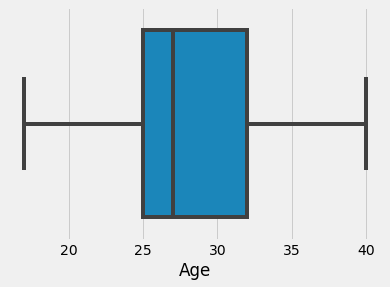

In [ ]:
sns.boxplot(x=dataset['Age'])

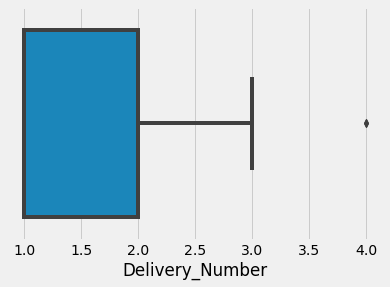

In [ ]:
sns.boxplot(x=dataset['Delivery_Number'])

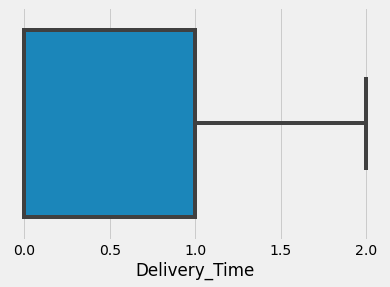

In [ ]:
sns.boxplot(x=dataset['Delivery_Time'])

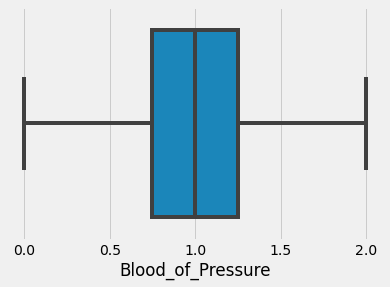

In [ ]:
sns.boxplot(x=dataset['Blood_of_Pressure'])

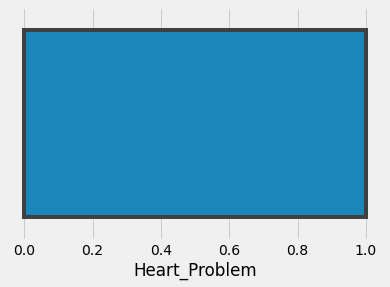

In [ ]:
sns.boxplot(x=dataset['Heart_Problem'])

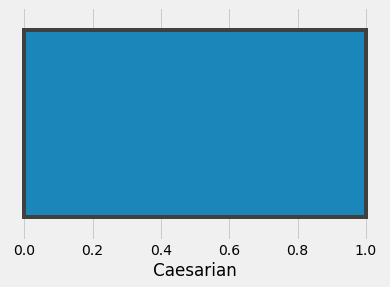

In [ ]:
sns.boxplot(x=dataset['Caesarian'])

Como podemos observar, só temos um boxplot apresentando um outlier, que é o de número de bebês do parto. Como são apenas dois valores discrepantes em toda a base de dados (dois partos de quadrigêmeos), vamos removê-los sem danos a nossa base de dados.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


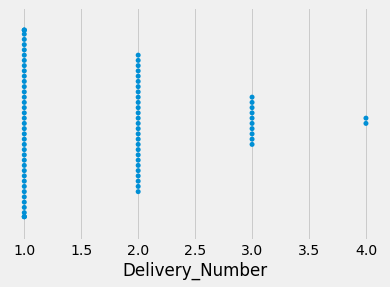

In [ ]:
sns.swarmplot(x=dataset['Delivery_Number'])

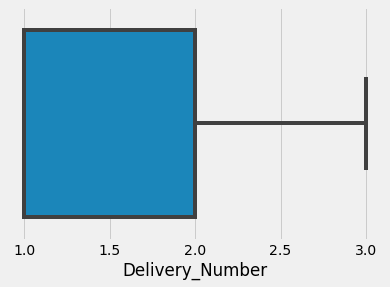

In [ ]:
Q1=dataset['Delivery_Number'].quantile(0.25)
Q3=dataset['Delivery_Number'].quantile(0.75)
IQR=Q3-Q1
lowqe_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR
dataset['Delivery_Number'] = dataset['Delivery_Number'][~((dataset['Delivery_Number'] < lowqe_bound) |(dataset['Delivery_Number'] > upper_bound))]
sns.boxplot(x=dataset['Delivery_Number'])

In [ ]:
dataset.isna().sum()

Age                  0
Delivery_Number      2
Delivery_Time        0
Blood_of_Pressure    0
Heart_Problem        0
Caesarian            0
dtype: int64

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 79
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                78 non-null     int64  
 1   Delivery_Number    78 non-null     float64
 2   Delivery_Time      78 non-null     int64  
 3   Blood_of_Pressure  78 non-null     int64  
 4   Heart_Problem      78 non-null     int64  
 5   Caesarian          78 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 4.3 KB


## Tarefa 1

### Divisão do conjunto de dados

In [ ]:
X = dataset.drop('Caesarian', axis=1)
y = dataset["Caesarian"]

### Particionamento simples

In [ ]:
def naive_bayes(X, y, size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=True, random_state=0)

  gnb = GaussianNB()
  gnb = gnb.fit(X_train, y_train)

  return gnb.score(X_test, y_test)

#### (i) 1/3 teste e 2/3 treino

In [ ]:
acuracia = naive_bayes(X, y, 1/3)
print(f"Acurácia: {acuracia*100}%")

Acurácia: 69.23076923076923%


#### (ii) 1/4 teste e 3/4 treino

In [ ]:
accuracy = naive_bayes(X,y,1/4)
print(f"Acurácia: {accuracy*100}%")

Acurácia: 70.0%


### Validação cruzada

In [ ]:
def validacaocruzada(k, X, y):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    avgaccur = []

    for train_index, test_index in kf.split(X):
        gnb = GaussianNB()

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gnb = gnb.fit(X_train, y_train)

        accur = gnb.score(X_test, y_test)

        avgaccur.append(accur)

    return sum(avgaccur)/len(avgaccur)

In [ ]:
bestaccur = 0
bestk = 5

for k in range(5, 11):
    accur = validacaocruzada(k, X, y)
    print(f"k = {k} \t{100 * accur}%")

    if accur > bestaccur:
        bestaccur = accur
        bestk = k

print(f"\nO mais acurado foi k = {bestk} - {100 * bestaccur}%")

k = 5 	65.25000000000001%
k = 6 	67.94871794871796%
k = 7 	66.66666666666666%
k = 8 	68.05555555555556%
k = 9 	63.888888888888886%
k = 10 	65.53571428571428%

O mais acurado foi k = 8 - 68.05555555555556%


### Divisão estratificada de dados

#### Particionamento simples estratificado

In [ ]:
def particionamentosimplesestratificado(X, Y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=test_size, shuffle=True, random_state=0)

    gnb = GaussianNB()

    gnb = gnb.fit(X_train, y_train)

    accur = gnb.score(X_test, y_test)

    return accur

In [ ]:
accur3 = particionamentosimplesestratificado(X, y, 1/3)
accur4 = particionamentosimplesestratificado(X, y, 1/4)
print(f"{accur3*100}%")
print(f"{accur4*100}%")

69.23076923076923%
75.0%


#### Validação cruzada estratificada

In [ ]:
def validacaocruzadaestratificada(k, X, Y):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
    gnb = GaussianNB()

    avgaccur = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        gnb.fit(X_train, y_train)

        accur = gnb.score(X_test, y_test)

        avgaccur.append(accur)

    return sum(avgaccur)/len(avgaccur)

In [ ]:
bestaccur = 0
bestk = 5

for k in range(5, 11):
    accur = validacaocruzadaestratificada(k, X, y)
    print(f"k = {k} \t{100 * accur}%")

    if accur > bestaccur:
        bestaccur = accur
        bestk = k

print(f"\nO mais acurado foi k = {bestk} - {100 * bestaccur}%")

k = 5 	65.5%
k = 6 	64.1025641025641%
k = 7 	65.47619047619048%
k = 8 	63.33333333333333%
k = 9 	64.6604938271605%
k = 10 	63.39285714285714%

O mais acurado foi k = 5 - 65.5%


## Tarefa 2

Como foi possível observar, o melhor esquema de particionamento foi o particionamento simples estratificado com test size igual a 1/4

### Árvores de decisão

Performance do Naive Bayes
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.80      0.73      0.76        11

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20

Performance da árvore de decisão
              precision    recall  f1-score   support

           0       0.50      0.56      0.53         9
           1       0.60      0.55      0.57        11

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



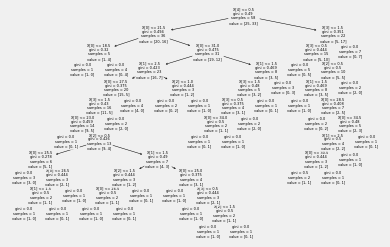

In [ ]:
def bestaccuracygini(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1/4, shuffle=True, random_state=0)

    modelDT = tree.DecisionTreeClassifier(criterion="gini")

    gnb = GaussianNB()

    gnb = gnb.fit(X_train, y_train)

    modelDT = modelDT.fit(X_train, y_train)

    plot_tree(modelDT)

    y_pred = gnb.predict(X_test)
    print("Performance do Naive Bayes")
    print(metrics.classification_report(y_test,y_pred))

    print("Performance da árvore de decisão")
    y_pred = modelDT.predict(X_test)
    print(metrics.classification_report(y_test,y_pred))

bestaccuracygini(X, y)

Performance do Naive Bayes
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.80      0.73      0.76        11

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20

Performance da árvore de decisão
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.55      0.55      0.55        11

    accuracy                           0.50        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.50      0.50      0.50        20



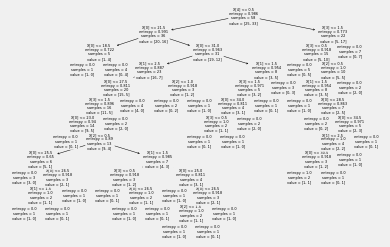

In [ ]:
def bestaccuracyentropy(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=1/4, shuffle=True, random_state=0)

    modelDT = tree.DecisionTreeClassifier(criterion="entropy")

    gnb = GaussianNB()

    gnb = gnb.fit(X_train, y_train)

    modelDT = modelDT.fit(X_train, y_train)

    plot_tree(modelDT)

    y_pred = gnb.predict(X_test)
    print("Performance do Naive Bayes")
    print(metrics.classification_report(y_test,y_pred))

    print("Performance da árvore de decisão")
    y_pred = modelDT.predict(X_test)
    print(metrics.classification_report(y_test,y_pred))



bestaccuracyentropy(X, y)

Essas árvores estão praticamente incompreensíveis. Enquanto buscávamos soluções para isso, encontramos um artigo do Mineirando Dados ([link](https://www.https://minerandodados.com.br/arvores-de-decisao-conceitos-e-aplicacoes/)) que falava sobre árvores de decisão e trazia uma solução interativa para controlar o crescimento da árvore baseado nos parâmetros:


1.   Criterio (gini ou entropy);
2.   Split (best ou random);
3.   Minimo de samples por split;
4.   Minimo de samples por folha da árvore.
5.   Profundidade máxima da árvore

Resolvemos trazer para cá este código a fim de garantir uma melhor visualização.



In [ ]:
X,y = dataset.drop('Caesarian',axis=1), dataset['Caesarian']

features_label = dataset.drop('Caesarian',axis=1).columns

class_label = ['0','1']


def plot_tree_(crit, split, depth, min_samples_split, min_samples_leaf=0.2):
    estimator = DecisionTreeClassifier(
           random_state = 0
          ,criterion = crit
          ,splitter = split
          ,max_depth = depth
          ,min_samples_split=min_samples_split
          ,min_samples_leaf=min_samples_leaf
    )
    estimator.fit(X, y)
    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features_label
      , class_names=class_label
      , impurity=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree_
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4,5,10,20,30]
   , min_samples_split=(1,5)
   , min_samples_leaf=(1,5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Matriz de confusão e Curva ROC para Naive Bayes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


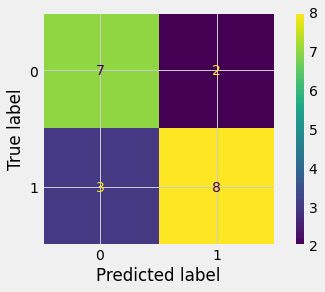

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1/4, shuffle=True, random_state=0)

gnb = GaussianNB()

gnb = gnb.fit(X_train, y_train)

plot_confusion_matrix(gnb, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


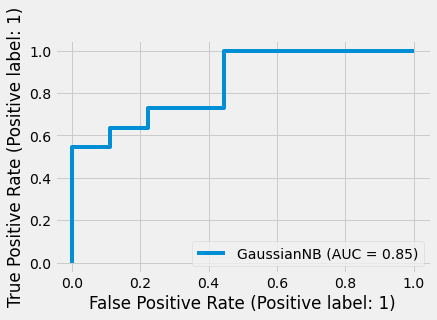

In [ ]:
metrics.plot_roc_curve(gnb, X_test, y_test)

### Matriz de Confusão e Curva ROC para a Árvore de Decisão

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


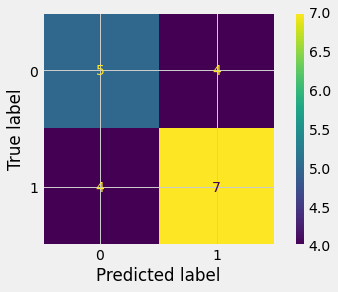

In [ ]:
modelDT = tree.DecisionTreeClassifier()
modelDT = modelDT.fit(X_train, y_train)

plot_confusion_matrix(modelDT, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


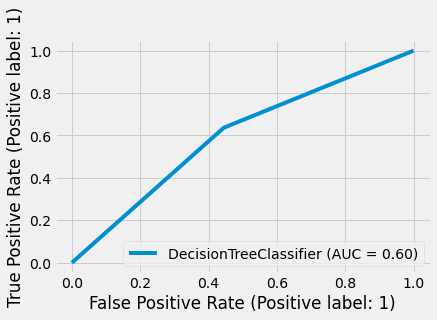

In [ ]:
metrics.plot_roc_curve(modelDT, X_test, y_test)

## Tarefa 3

Para esta parte da tarefa, achamos que seria mais simples optar por um dataset com apenas duas colunas. Então, do site que foi disponibilizado pelo professor, filtramos a Default Task por Clustering e ordenamos as bases de dados pelo número de colunas, do menor pro maior, encontrando um dataset que contem as coordenadas de acidentes de estrada nas áreas urbanas da Grâ-Bretanha (arquivo em anexo).

In [ ]:
dataset = pd.read_csv('sample_data/urban.csv')

dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360177 entries, 0 to 360176
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   longitude  360177 non-null  float64
 1   latitude   360177 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB


,longitude,latitude
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


In [ ]:
n_values_to_plot = 10000

### Selecionando o número de clusters através do método Elbow com init = k-means++

In [ ]:
X2 = dataset.values
inertia = []

for n in range(1, 11):
    algoritmo = (KMeans(n_clusters=n))
    algoritmo.fit(X2)
    inertia.append(algoritmo.inertia_)

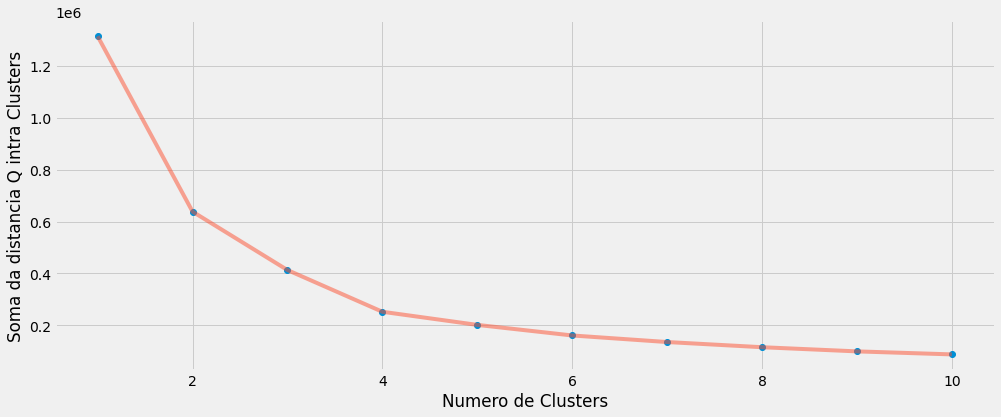

In [ ]:
plt.figure(1, figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')
plt.plot(np.arange(1,11), inertia, '-', alpha = 0.5)
plt.xlabel('Numero de Clusters'), plt.ylabel('Soma da distancia Q intra Clusters')
plt.show()

Numero de clusters e de centroides: 3

In [ ]:
algoritmo = (KMeans(n_clusters=3))
algoritmo.fit(X2)

y = algoritmo.predict(X2)
y

array([2, 1, 0, ..., 0, 2, 1], dtype=int32)

### Inicializando KMeans com 3 clusters, de acordo com o resultado do método Elbow, com init = k-means++

In [ ]:
algorithm = (KMeans(n_clusters = 3,init='k-means++',max_iter=300,random_state=0))
algorithm.fit(X2)
y = algorithm.predict(dataset)
y


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0, 2, 1, ..., 1, 0, 2], dtype=int32)

##### Máximo de iterações: 100

In [ ]:
algorithm = KMeans(n_clusters=3, max_iter=100)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 1, 2, ..., 2, 0, 1], dtype=int32)

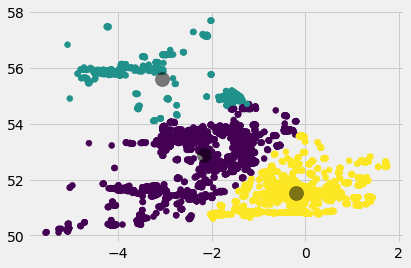

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


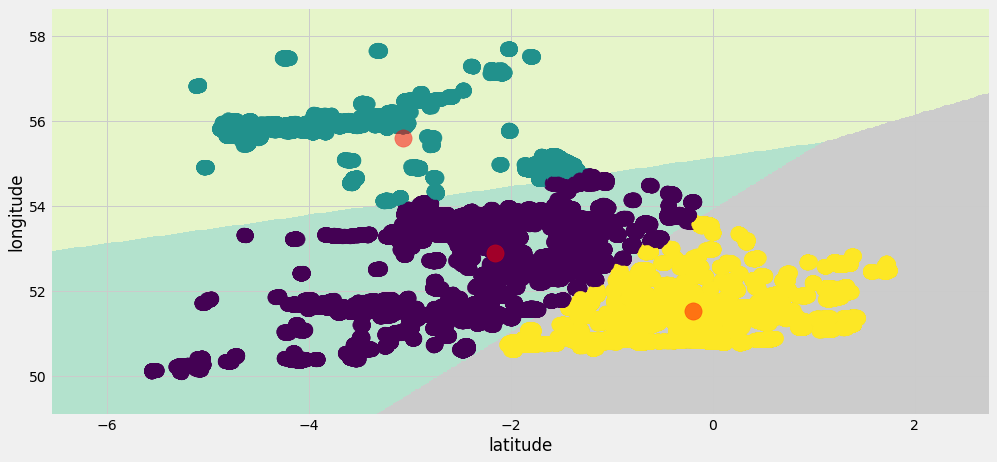

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 200

In [ ]:
algorithm = KMeans(n_clusters=3, max_iter=200)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 2, 1, ..., 1, 0, 2], dtype=int32)

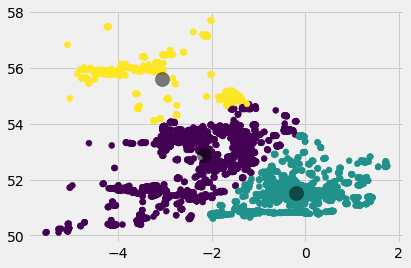

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


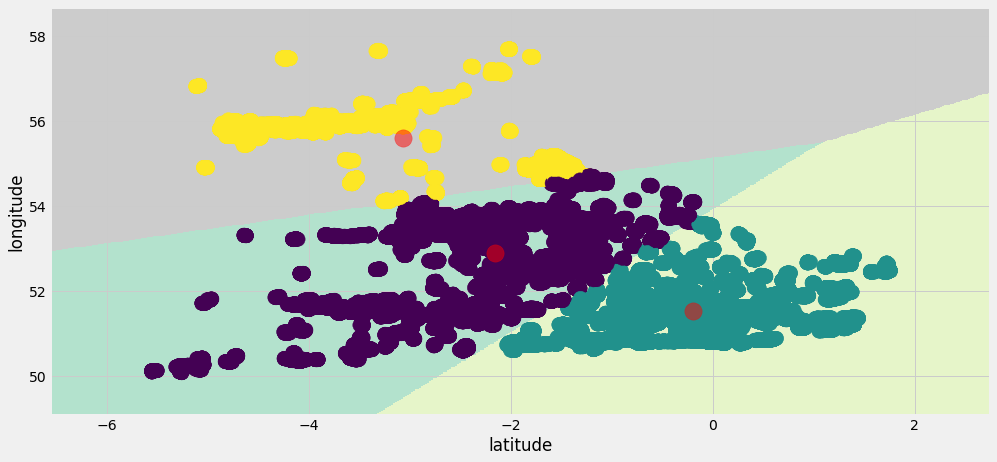

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 300

In [ ]:
algorithm = KMeans(n_clusters=3, max_iter=300)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([2, 1, 0, ..., 0, 2, 1], dtype=int32)

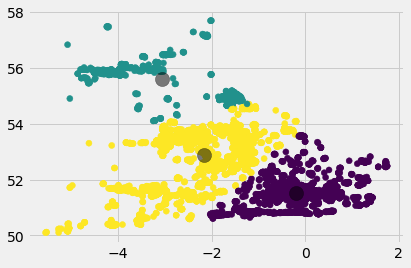

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


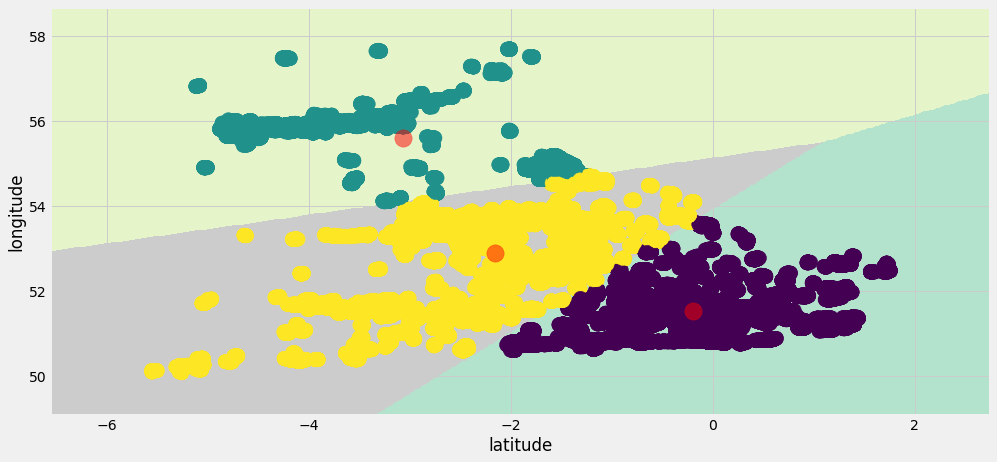

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

### Inicializando KMeans com 4 clusters, como alternativa ao resultado do método Elbow, com init = k-means++

In [ ]:
algorithm = (KMeans(n_clusters = 4,init='k-means++',max_iter=300,random_state=0))
algorithm.fit(X2)
y = algorithm.predict(dataset)
y


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0, 3, 1, ..., 1, 0, 3], dtype=int32)

##### Máximo de iterações: 100

In [ ]:
algorithm = KMeans(n_clusters=4, max_iter=100)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([3, 2, 0, ..., 0, 3, 2], dtype=int32)

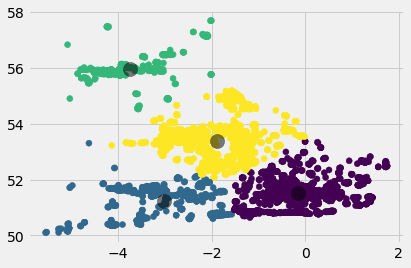

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


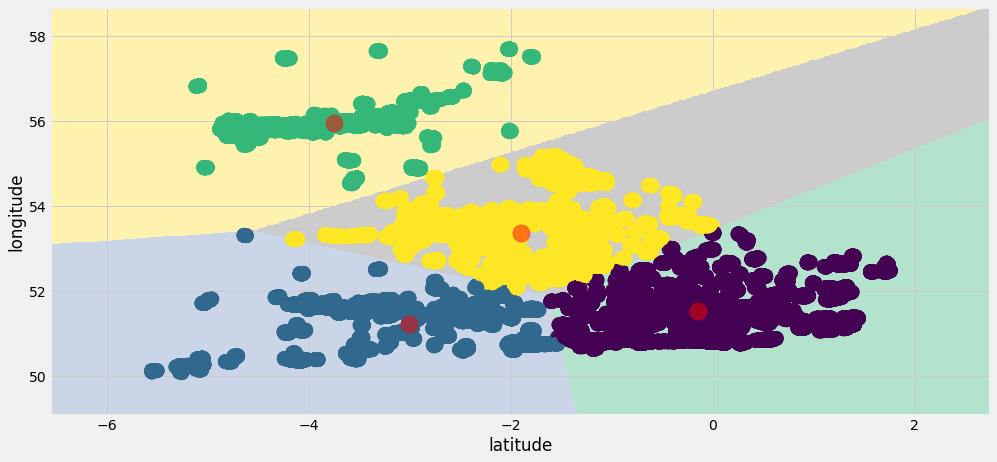

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 200

In [ ]:
algorithm = KMeans(n_clusters=4, max_iter=200)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([1, 0, 3, ..., 3, 1, 0], dtype=int32)

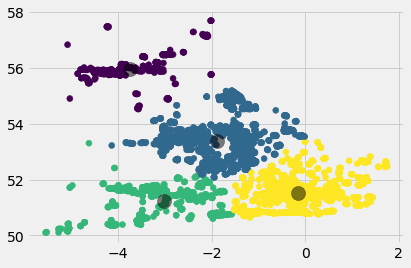

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


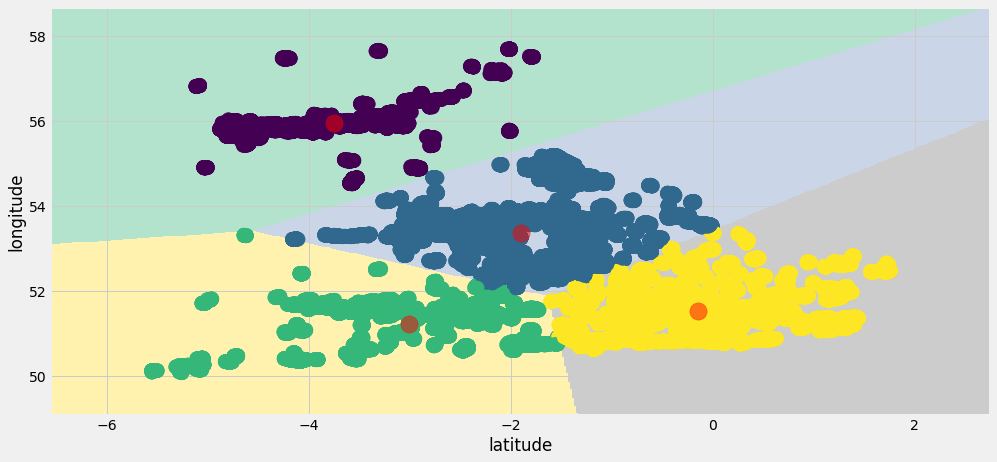

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 300

In [ ]:
algorithm = KMeans(n_clusters=4, max_iter=300)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([1, 3, 2, ..., 2, 1, 3], dtype=int32)

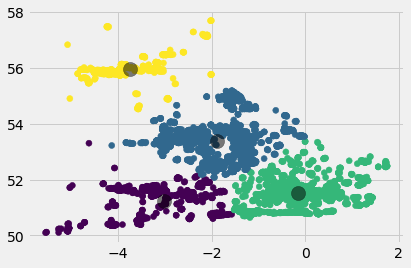

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


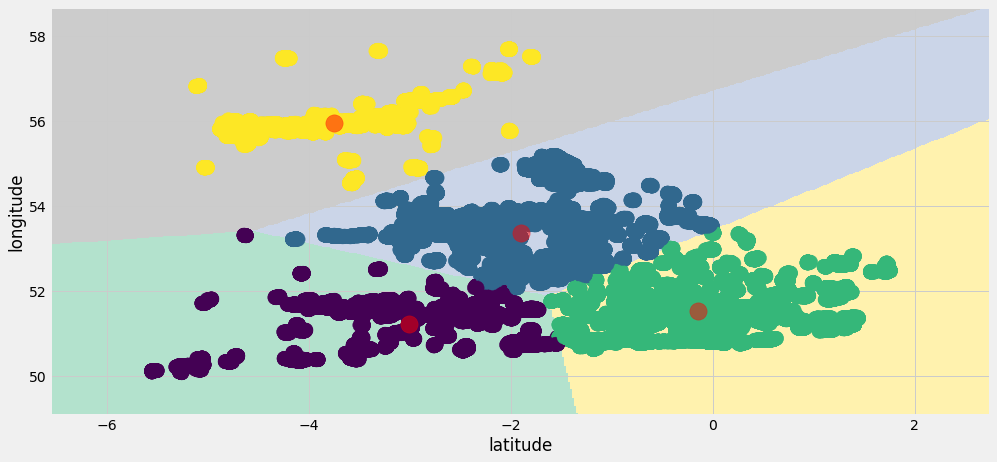

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

### Selecionando o número de clusters através do método Elbow com init = random

In [ ]:
X2 = dataset.values
inertia = []

for n in range(1, 11):
    algoritmo = (KMeans(n_clusters=n, init='random'))
    algoritmo.fit(X2)
    inertia.append(algoritmo.inertia_)

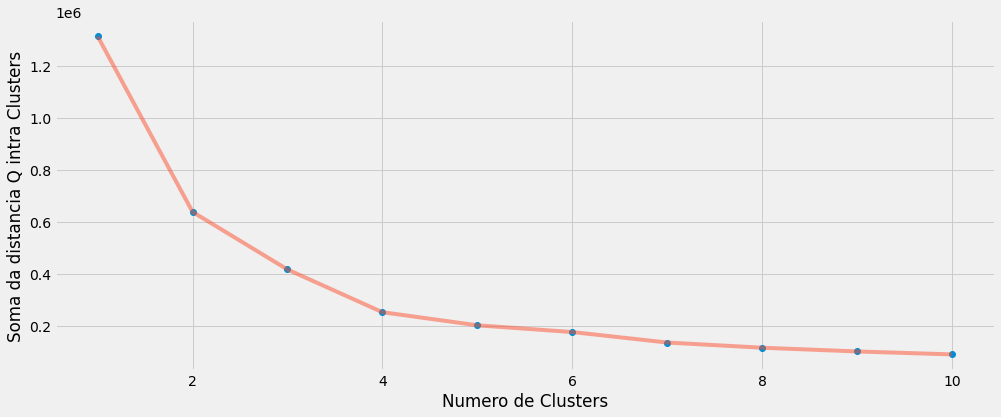

In [ ]:
plt.figure(1, figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')
plt.plot(np.arange(1,11), inertia, '-', alpha = 0.5)
plt.xlabel('Numero de Clusters'), plt.ylabel('Soma da distancia Q intra Clusters')
plt.show()

Novamente, 3 clusters e 3 centroides

In [ ]:
algorithm = (KMeans(n_clusters = 3,init='random',max_iter=300,random_state=0))
algorithm.fit(X2)
y = algorithm.predict(dataset)
y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([2, 0, 1, ..., 1, 2, 0], dtype=int32)

In [ ]:
resul = []

for k in range(100,325,25):
    algorithm = (KMeans(n_clusters = 3,init='random',max_iter=k))
    algorithm.fit(X2)
    resul.append(algorithm.cluster_centers_)

column = [ f"Q{elem}" for elem in range(1,6) ]
r = []

for li in resul:
    value = []
    for col in li:
       value.append(list(col))

    r.append(value)

### Inicializando KMeans com 3 clusters, de acordo com o resultado do método Elbow, com init = random

In [ ]:
algorithm = (KMeans(n_clusters = 3,init='random',max_iter=300,random_state=0))
algorithm.fit(X2)
y = algorithm.predict(dataset)
y


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([2, 0, 1, ..., 1, 2, 0], dtype=int32)

##### Máximo de iterações: 100

In [ ]:
algorithm = KMeans(n_clusters=3,init='random', max_iter=100)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 2, 1, ..., 1, 0, 2], dtype=int32)

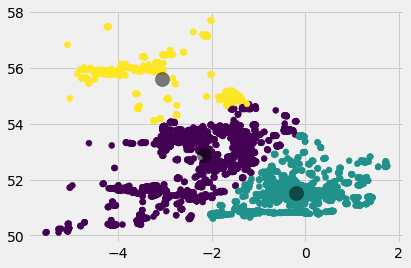

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


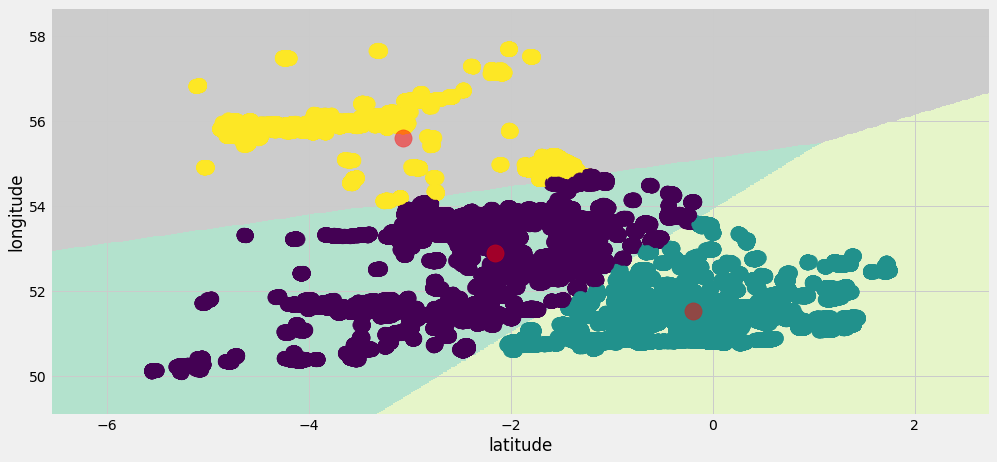

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 200

In [ ]:
algorithm = KMeans(n_clusters=3,init='random', max_iter=200)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 2, 1, ..., 1, 0, 2], dtype=int32)

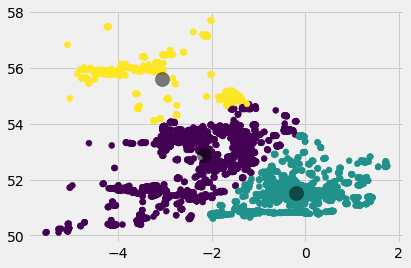

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


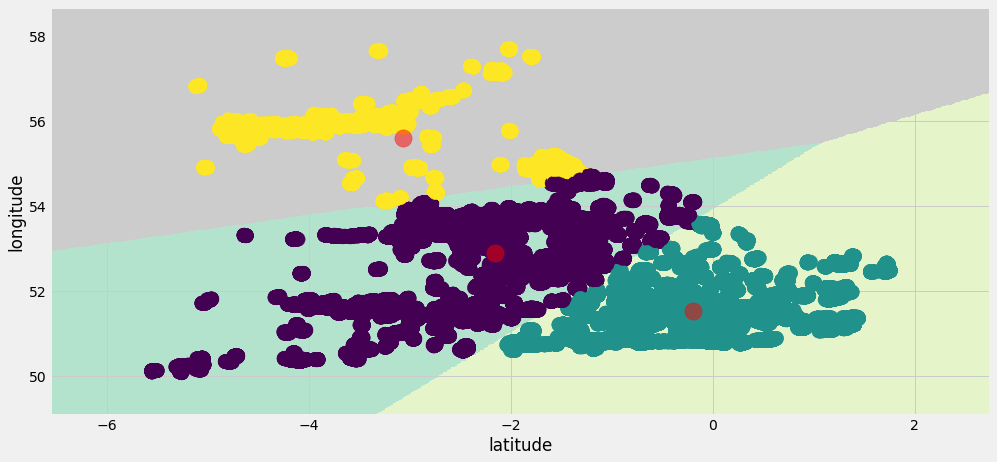

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 300

In [ ]:
algorithm = KMeans(n_clusters=3, init='random', max_iter=300)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 1, 2, ..., 2, 0, 1], dtype=int32)

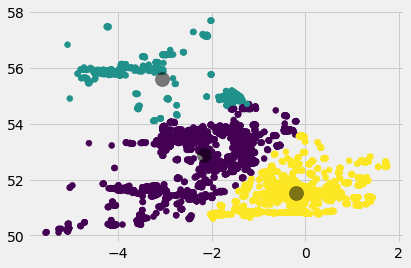

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


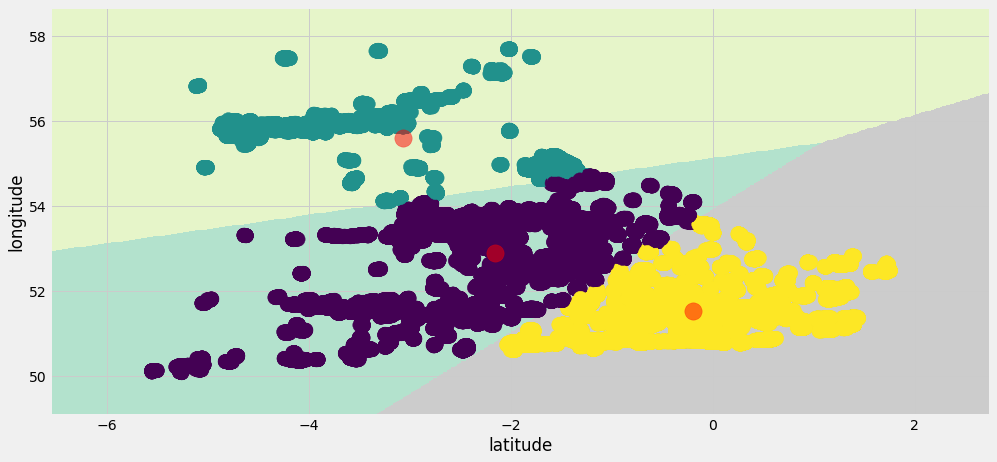

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

### Inicializando KMeans com 4 clusters, como alternativa ao resultado do método Elbow, com init = random

In [ ]:
algorithm = (KMeans(n_clusters = 4,init='random',max_iter=300,random_state=0))
algorithm.fit(X2)
y = algorithm.predict(dataset)
y


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([3, 0, 1, ..., 1, 3, 0], dtype=int32)

##### Máximo de iterações: 100

In [ ]:
algorithm = KMeans(n_clusters=4, init='random', max_iter=100)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([2, 1, 0, ..., 0, 2, 1], dtype=int32)

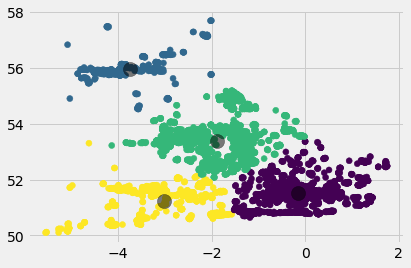

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


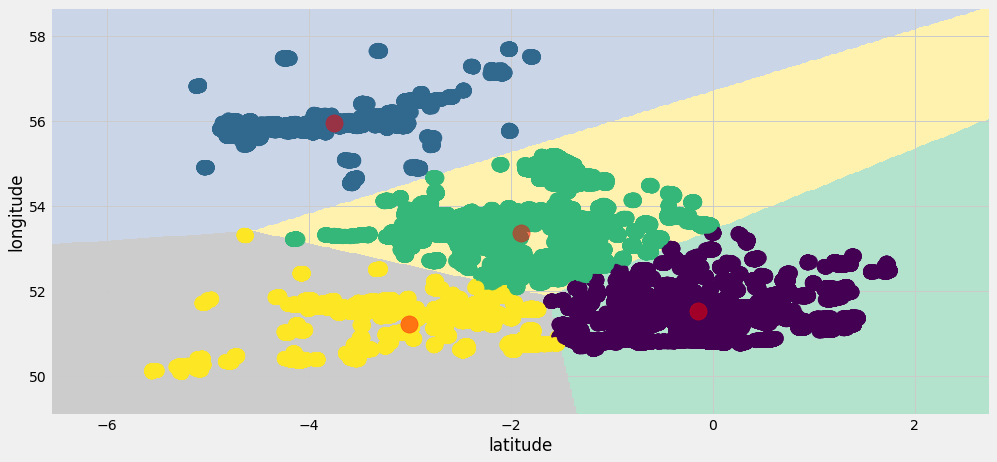

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 200

In [ ]:
algorithm = KMeans(n_clusters=4, init='random',max_iter=200)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([3, 0, 2, ..., 2, 3, 0], dtype=int32)

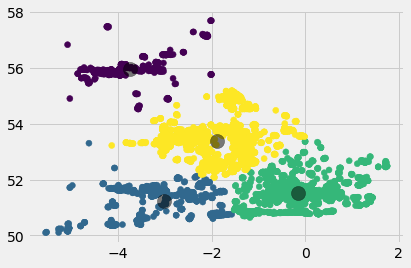

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


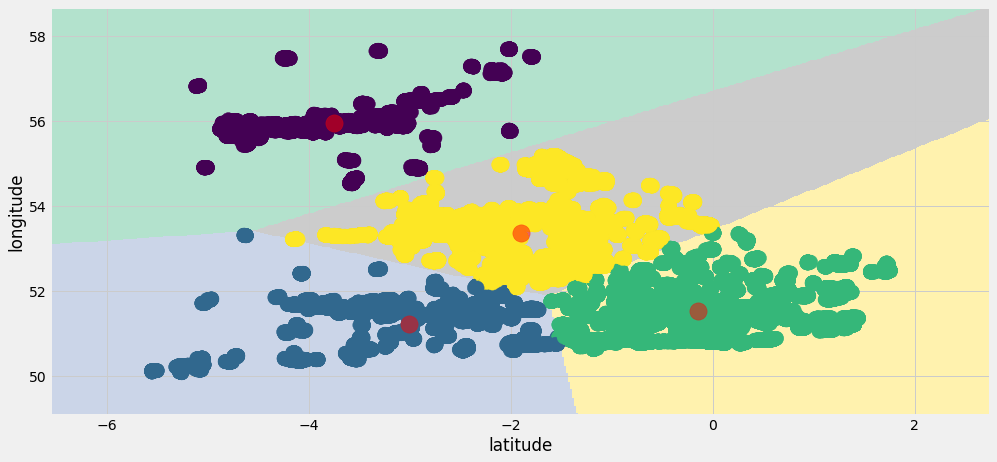

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

##### Máximo de iterações: 300

In [ ]:
algorithm = KMeans(n_clusters=4, init='random', max_iter=300)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 2, 3, ..., 3, 0, 2], dtype=int32)

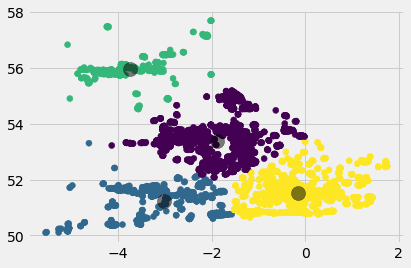

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


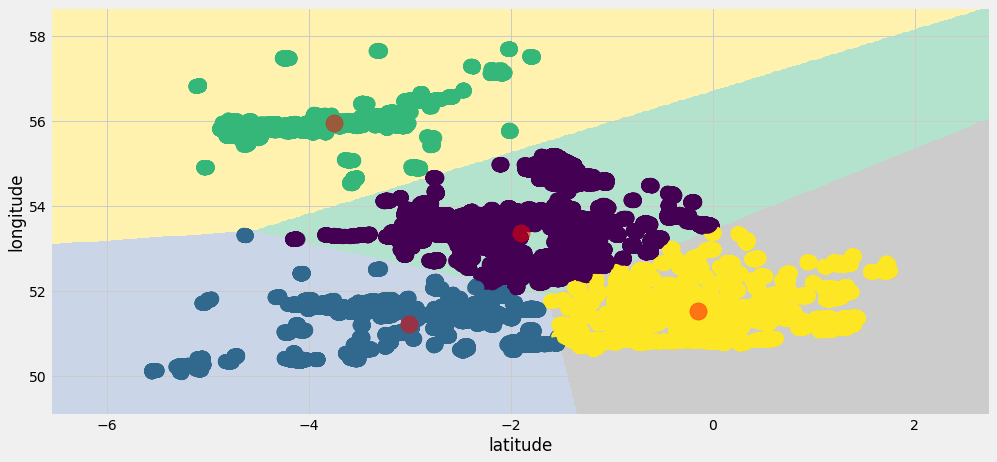

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

### Decidindo o melhor numero de clusters baseado no método da Silhueta

In [ ]:
silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(X)
  score = silhouette_score(X, kmeans.labels_)
  silhouette_coefficients.append(score)

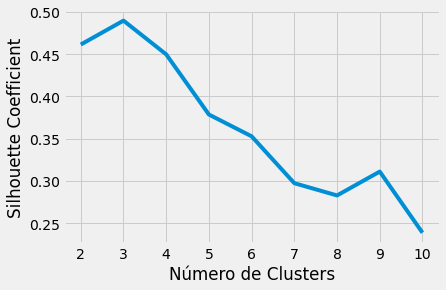

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Número ótimo de clusters (Elbow e Silhueta): **3**

### Conclusão

Fazendo a análise dos gráficos com número de clusters igual a 3 (valor acordado entre o Método Elbow e o Coeficiente Silhueta), podemos perceber que a diferença é pouca entre os gráficos apresentados para numero de clusters k = 3. Os centroides em todos os graficos apresentam o padrão de fazer uma linha. Portanto, decidimos que o melhor agrupamento fica com o menor número de iterações do algoritmo k-means para uma única execução (100), com método de inicialização k-means++ (padrão) e número de clusters k=3.

In [ ]:
algorithm = KMeans(n_clusters=3, max_iter=100)
algorithm.fit(dataset)
y = algorithm.predict(dataset)
y

array([0, 2, 1, ..., 1, 0, 2], dtype=int32)

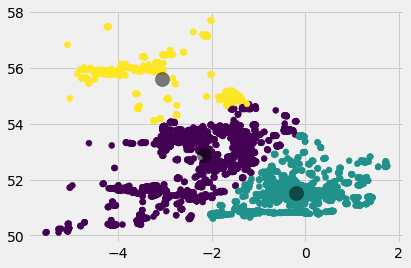

In [ ]:
plt.scatter(dataset["longitude"].iloc[:n_values_to_plot], dataset["latitude"].iloc[:n_values_to_plot], c=y[:n_values_to_plot])
centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


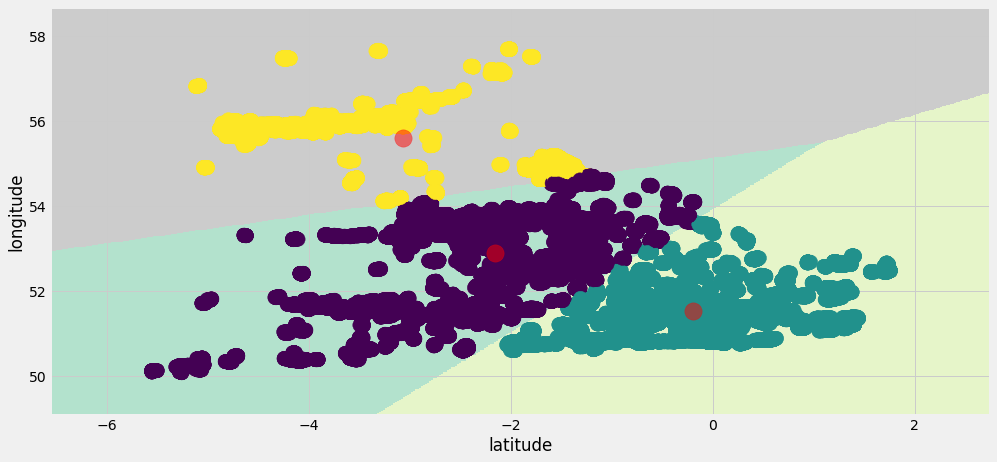

In [ ]:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'longitude' ,y = 'latitude' , data = dataset , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('longitude') , plt.xlabel('latitude')
plt.show()

In [ ]:
dataset["cluster"] = algorithm.labels_
dataset_group = dataset.groupby("cluster")
dataset_group.describe()

longitude                      ... latitude                  
            count      mean       std  ...      50%      75%      max
cluster                                ...                           
0        174639.0 -2.156624  0.818522  ...  53.1942  53.5475  54.7076
1        152396.0 -0.192282  0.618779  ...  51.5086  51.6001  53.6175
2         33142.0 -3.065546  1.153655  ...  55.8372  55.9338  57.6956

[3 rows x 16 columns]